In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.datasets import load_digits

import matplotlib.ticker as mtick
import seaborn as sns

sns.set()

#seed = np.random.seed(3)

In [2]:
df = pd.read_csv('nhlanalysis/data/extracted/shot_goal_20151007_20210707.csv')
df = df.apply(pd.to_numeric, args=('ignore',))

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

df_dropped = df_dropped[['isGoal', 'speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType']]

df_dropped['emptyNet'] = df_dropped['emptyNet'].fillna(0)
df_dropped['strength'] = df_dropped['strength'].fillna('Even')

dummy_object = pd.get_dummies(df_dropped[['strength', 'shotType', 'prevEvent']])
df_dropped = df_dropped.merge(dummy_object, left_index=True, right_index=True)
df_dropped = df_dropped.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

df_dropped = df_dropped.dropna(how='any')

#non standardized data
#train, test = train_test_split(df_dropped, test_size=0.2, random_state=42)
#print(train.shape)
#print(test.shape)

#x = train[df_dropped.columns.drop(labels = 'isGoal')].to_numpy().reshape(-1, 35)

#y = train['isGoal'].to_numpy()

#x_test = test[df_dropped.columns.drop(labels = 'isGoal')].to_numpy().reshape(-1, 35)

#y_test = test['isGoal'].to_numpy()

#x, y = RandomUnderSampler(random_state=42).fit_resample(x, y)

#print(x.shape)
#print(x_test.shape)
#print(y_test.shape)

<AxesSubplot:>

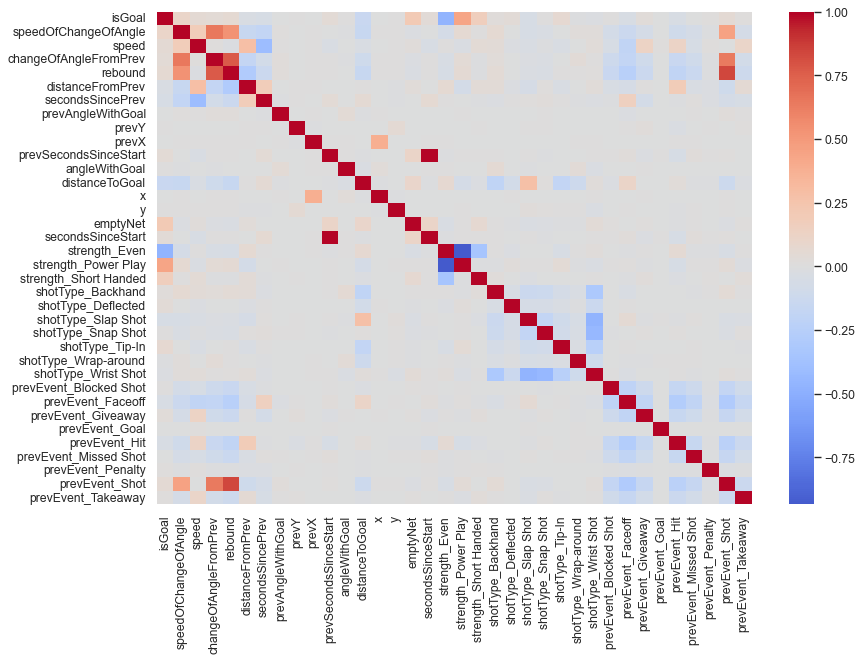

In [3]:
corr = df_dropped.corr()
figure(figsize=(12, 8), dpi=80)
sns.heatmap(corr, center= 0, cmap= 'coolwarm')

In [4]:
#standardized data 

#split with shuffle 
train, test = train_test_split(df_dropped, test_size=0.2, random_state=42, shuffle = True)
print(train.shape)
print(test.shape)


x = train[df_dropped.columns.drop(labels = 'isGoal')]

#standardized training set
scaler = StandardScaler()
df_standardized = scaler.fit_transform(x)
x = pd.DataFrame(df_standardized, columns = x.columns)
x = x.to_numpy().reshape(-1, 35)

y = train['isGoal'].to_numpy()

x_test = test[df_dropped.columns.drop(labels = 'isGoal')]

#standardized validation set
scaler = StandardScaler()
df_standardized = scaler.fit_transform(x_test)
x_test = pd.DataFrame(df_standardized, columns = x_test.columns)
x_test = x_test.to_numpy().reshape(-1, 35)

y_test = test['isGoal'].to_numpy()

#balance training set
x, y = RandomUnderSampler(random_state=42).fit_resample(x, y)

print(x.shape)
print(x_test.shape)
print(y_test.shape)

print(x)
print(x_test)

(246966, 36)
(61742, 36)
(45410, 35)
(61742, 35)
(61742,)
[[-0.22074052 -0.28207697 -0.31592469 ... -0.02825451 -0.49188043
  -0.2719755 ]
 [-0.22074052 -0.66811752 -0.31592469 ... -0.02825451  2.03301443
  -0.2719755 ]
 [-0.22074052 -0.73228915 -0.31592469 ... -0.02825451 -0.49188043
  -0.2719755 ]
 ...
 [ 2.10720827  0.03060008  0.66273222 ... -0.02825451  2.03301443
  -0.2719755 ]
 [-0.22074052  1.17706411 -0.31592469 ... -0.02825451 -0.49188043
  -0.2719755 ]
 [-0.22074052 -0.49794958 -0.31592469 ... -0.02825451 -0.49188043
  -0.2719755 ]]
[[ 0.46543152 -0.50252672  0.82584517 ... -0.0257778   2.03365462
  -0.27202583]
 [-0.07085481 -0.67434947  0.12543212 ... -0.0257778   2.03365462
  -0.27202583]
 [-0.22326678 -0.66501015 -0.31728081 ... -0.0257778  -0.49172558
  -0.27202583]
 ...
 [-0.10830565 -0.62948088 -0.17416837 ... -0.0257778   2.03365462
  -0.27202583]
 [-0.22326678 -0.61444187 -0.31728081 ... -0.0257778  -0.49172558
  -0.27202583]
 [ 0.59104711  0.56088779  0.6964396  ..

### Méthode f-classif/ mutual_info_classif : 10 caractéristiques (paramètre par défaut)

#### f-classif (paramètres par défaut) 

In [5]:
#use selectKbest with f_classif to select best 10 features
x_new = SelectKBest(score_func = f_classif)
a = x_new.fit(x, y)

#Transform traing and validation set
x_transform_train = a.transform(x)
x_transform_test = a.transform(x_test)

In [6]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new.get_support()})
kept_features[kept_features['Features selected'] == True]

,Features,Features selected
0,speedOfChangeOfAngle,True
3,rebound,True
5,secondsSincePrev,True
11,distanceToGoal,True
14,emptyNet,True
16,strength_Even,True
17,strength_Power Play,True
18,strength_Short Handed,True
21,shotType_Slap Shot,True
23,shotType_Tip-In,True


In [7]:
#Set hyper-parameters to optimize 
params = {
 'learning_rate' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
 'max_depth' : [2, 3, 4, 5, 6],
 'min_child_weight' : [2, 3, 4, 5, 6],
 'gamma': [0.0, 0.1, 0.2, 0.3],
 'colsample_bytree' : [0.3, 0.4, 0.45, 0.5, 0.6], 
    'n_estimators': [300, 500, 700, 900, 1200, 1500, 1700] 
}

In [8]:
#instantiate model
xgb_classifier1 = xgb.XGBClassifier(use_label_encoder=False, seed = 42)

#Random search for best hyper-parameters
xgbBest = RandomizedSearchCV(xgb_classifier1, param_distributions = params, n_iter=30, scoring='roc_auc', cv =5, refit=True, random_state = 42) #important for the feature selection, without it = scikit learn API problem

#Fit model 
xgb1 = xgbBest.fit(x_transform_train, y, eval_metric='rmse')

In [ ]:
xgbBest.cv_results_

In [10]:
xgbBest.best_params_

{'n_estimators': 1500,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.01,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [23]:
xgbBest.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [24]:
xgbBest.best_score_

0.8129214064268779

In [25]:
#Predictions 
y_pred_1 = xgb1.predict(x_transform_test)
score_prob_1 = xgb1.predict_proba(x_transform_test)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_1)}')
print(f'f1 score with 10 selected features with f-classif method: {f1_score(y_test, y_pred_1)}')

accuracy with 10 selected features with f-classif method: 0.7266690421431117
f1 score with 10 selected features with f-classif method: 0.3230645808263137


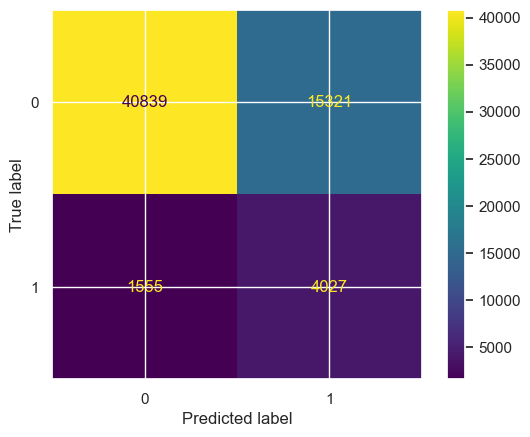

In [26]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_1)).plot()
plt.show()

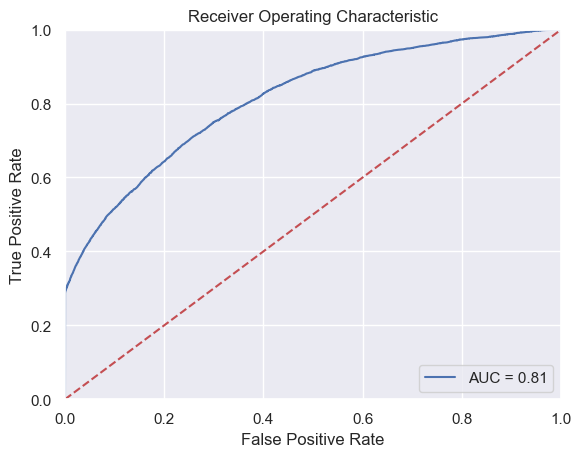

In [27]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

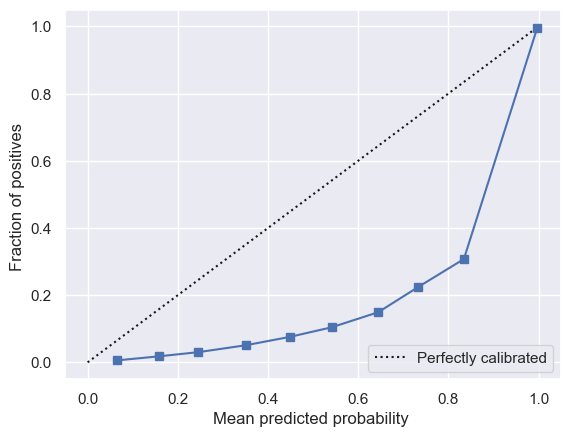

In [28]:
#plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, score_prob_1, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_1).plot()
plt.show()

#### mutual_info_classif (paramètres par défaut) 

In [29]:
#use selectKbest with f_classif to select best 10 features
x_new_2 = SelectKBest(score_func = mutual_info_classif)
a2 = x_new_2.fit(x, y)

#Transform traing and validation set
x_transform_train_2 = a2.transform(x)
x_transform_test_2 = a2.transform(x_test)

In [30]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new_2.get_support()})
kept_features[kept_features['Features selected'] == True]

,Features,Features selected
0,speedOfChangeOfAngle,True
1,speed,True
5,secondsSincePrev,True
10,angleWithGoal,True
11,distanceToGoal,True
12,x,True
13,y,True
14,emptyNet,True
16,strength_Even,True
17,strength_Power Play,True


In [33]:
#Fit model selected with best parameters xgb1 on new data
xgb2 = xgbBest.fit(x_transform_train_2, y, eval_metric='rmse')

In [34]:
#Predictions 
y_pred_2 = xgb2.predict(x_transform_test_2)
score_prob_2 = xgb2.predict_proba(x_transform_test_2)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_2)}')
print(f'f1 score with 10 selected features with f-classif method : {f1_score(y_test, y_pred_2)}')

accuracy with 10 selected features with f-classif method: 0.7359172038482719
f1 score with 10 selected features with f-classif method : 0.3340820910761691


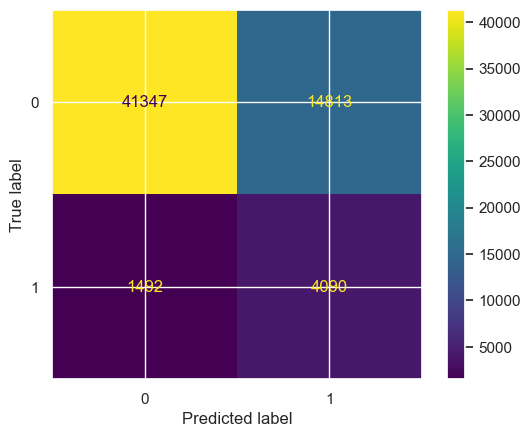

In [35]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_2)).plot()
plt.show()

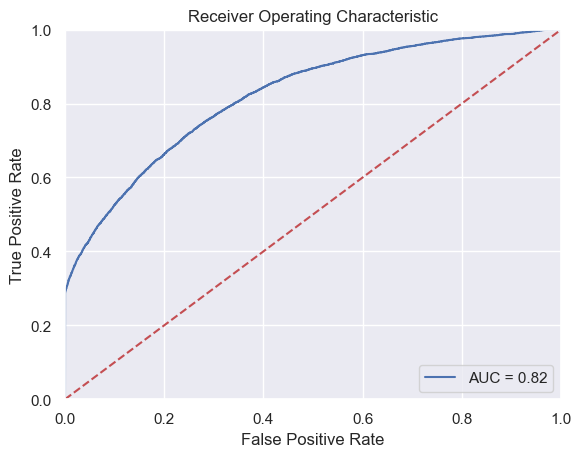

In [36]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

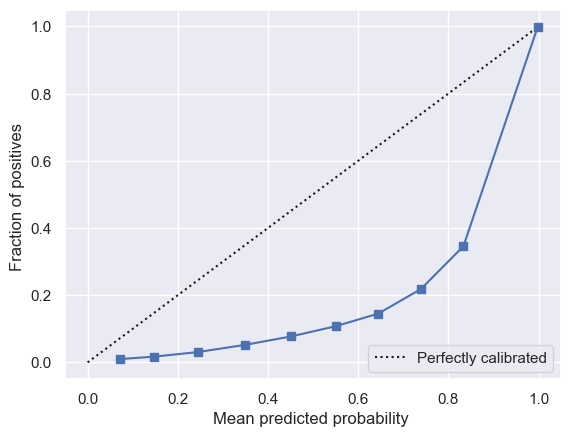

In [37]:
#plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, score_prob_2, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_2).plot()
plt.show()

### Méthode f-classif/ mutual_info_classif : 20 caractéristiques (paramètre par défaut)

#### f-classif : 20 caractéristiques 

In [38]:
#use selectKbest with f_classif to select best 20 features
x_new_3 = SelectKBest(score_func = f_classif, k=20)
a3 = x_new_3.fit(x, y)

#Transform traing and validation set
x_transform_train_3 = a3.transform(x)
x_transform_test_3 = a3.transform(x_test)

In [39]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new_3.get_support()})
kept_features[kept_features['Features selected'] == True]

,Features,Features selected
0,speedOfChangeOfAngle,True
1,speed,True
2,changeOfAngleFromPrev,True
3,rebound,True
4,distanceFromPrev,True
5,secondsSincePrev,True
9,prevSecondsSinceStart,True
11,distanceToGoal,True
14,emptyNet,True
15,secondsSinceStart,True


In [40]:
#Fit model selected with best parameters xgb1 on new data
xgb3 = xgbBest.fit(x_transform_train_3, y, eval_metric='rmse')

In [41]:
#Predictions 
y_pred_3 = xgb3.predict(x_transform_test_3)
score_prob_3 = xgb3.predict_proba(x_transform_test_3)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_3)}')
print(f'f1 score with 10 selected features with f-classif method : {f1_score(y_test, y_pred_3)}')

accuracy with 10 selected features with f-classif method: 0.7506721518577305
f1 score with 10 selected features with f-classif method : 0.33749354449991387


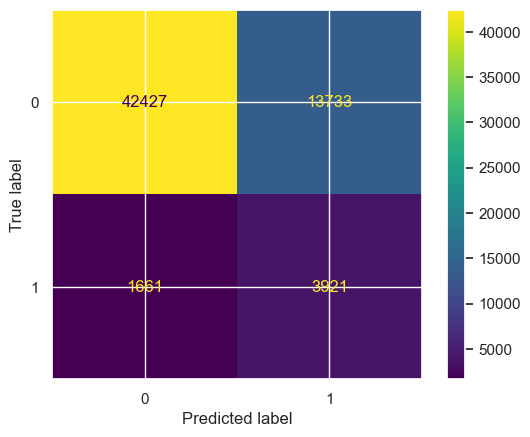

In [42]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_3)).plot()
plt.show()

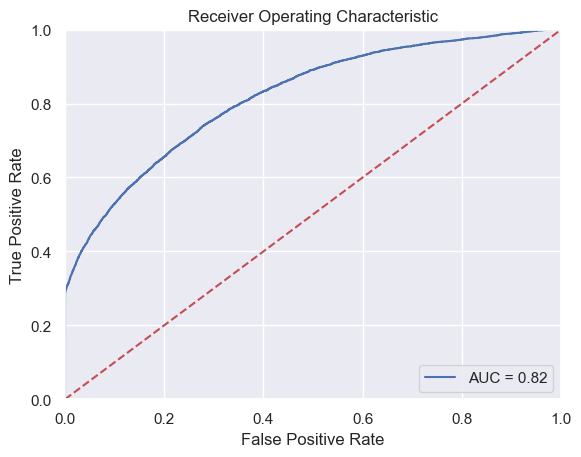

In [43]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_3)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

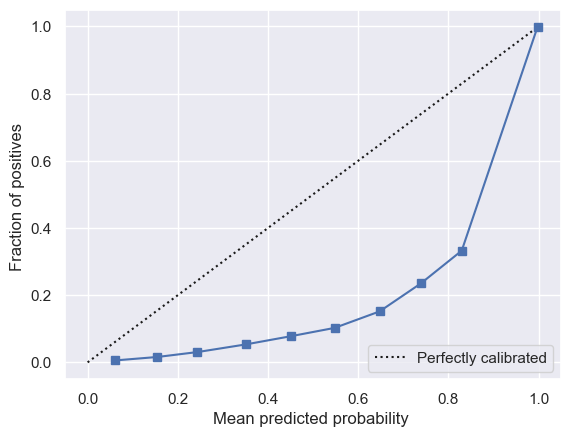

In [44]:
#plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, score_prob_3, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_3).plot()
plt.show()

#### mutual_info_classif : 20 caractéristiques 

In [45]:
#use selectKbest with f_classif to select best 20 features
x_new_4 = SelectKBest(score_func = mutual_info_classif, k=20)
a4 = x_new_4.fit(x, y)

#Transform traing and validation set
x_transform_train_4 = a4.transform(x)
x_transform_test_4 = a4.transform(x_test)

In [46]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new_4.get_support()})
kept_features[kept_features['Features selected'] == True]

,Features,Features selected
0,speedOfChangeOfAngle,True
1,speed,True
2,changeOfAngleFromPrev,True
4,distanceFromPrev,True
5,secondsSincePrev,True
7,prevY,True
8,prevX,True
9,prevSecondsSinceStart,True
10,angleWithGoal,True
11,distanceToGoal,True


In [47]:
#Fit model selected with best parameters xgb1 on new data
xgb4 = xgbBest.fit(x_transform_train_4, y, eval_metric='rmse')

In [48]:
#Predictions 
y_pred_4 = xgb4.predict(x_transform_test_4)
score_prob_4 = xgb4.predict_proba(x_transform_test_4)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_4)}')
print(f'f1 score with 10 selected features with f-classif method : {f1_score(y_test, y_pred_4)}')

accuracy with 10 selected features with f-classif method: 0.7418289009102393
f1 score with 10 selected features with f-classif method : 0.33930199784464893


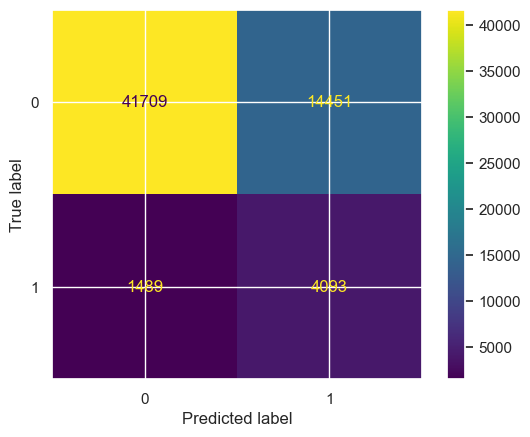

In [49]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_4)).plot()
plt.show()

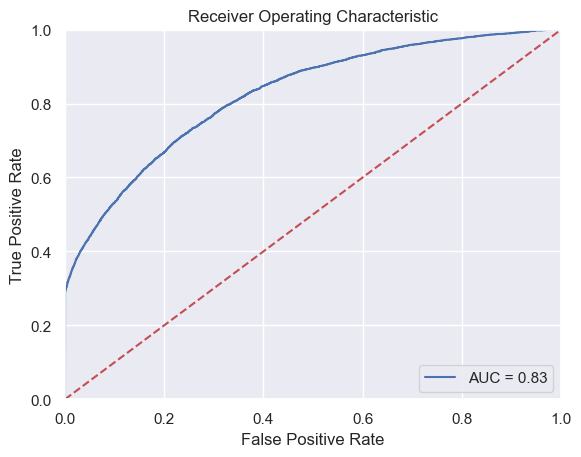

In [50]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_4)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

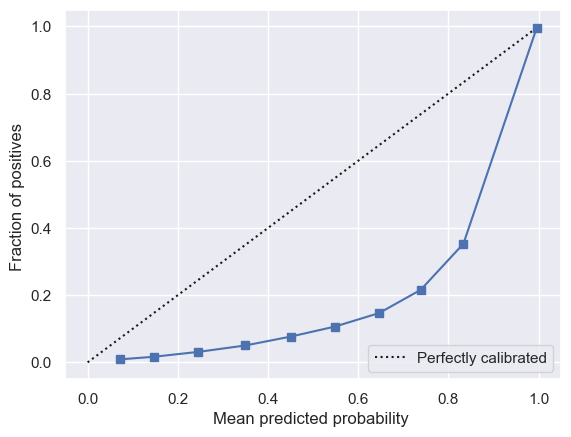

In [51]:
prob_true, prob_pred = calibration_curve(y_test, score_prob_4, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_4).plot()
plt.show()

### Méthode f-classif/ mutual_info_classif : 25 caractéristiques (paramètre par défaut)

#### f-classif : 25 caractéristiques 

In [52]:
#use selectKbest with f_classif to select best 20 features
x_new_5 = SelectKBest(score_func = f_classif, k=25)
a5 = x_new_5.fit(x, y)

#Transform traing and validation set
x_transform_train_5 = a5.transform(x)
x_transform_test_5 = a5.transform(x_test)

In [53]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new_5.get_support()})
kept_features[kept_features['Features selected'] == True]

,Features,Features selected
0,speedOfChangeOfAngle,True
1,speed,True
2,changeOfAngleFromPrev,True
3,rebound,True
4,distanceFromPrev,True
5,secondsSincePrev,True
9,prevSecondsSinceStart,True
11,distanceToGoal,True
14,emptyNet,True
15,secondsSinceStart,True


In [ ]:
#Fit model selected with best parameters (xgb1) on new data
xgb5 = xgb1.fit(x_transform_train_5, y, eval_metric='rmse')

In [66]:
#Predictions 
y_pred_5 = xgb5.predict(x_transform_test_5)
score_prob_5 = xgb5.predict_proba(x_transform_test_5)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_5)}')
print(f'f1 score with 10 selected features with f-classif method : {f1_score(y_test, y_pred_5)}')

In [67]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_5)).plot()
plt.show()

In [68]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_5)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
prob_true, prob_pred = calibration_curve(y_test, score_prob_5, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_5).plot()
plt.show()

#### mutual_info_classif : 20 caractéristiques 

In [70]:
#use selectKbest with f_classif to select best 20 features
x_new_6 = SelectKBest(score_func = mutual_info_classif, k=20)
a6 = x_new_6.fit(x, y)

#Transform traing and validation set
x_transform_train_6 = a6.transform(x)
x_transform_test_6 = a6.transform(x_test)

In [71]:
#features selected
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
kept_features = pd.DataFrame({'Features': x_labels.columns,
                              'Features selected': x_new_6.get_support()})
kept_features[kept_features['Features selected'] == True]

In [72]:
#Fit model selected with best parameters (xgb1) on new data
xgb6 = xgb1.fit(x_transform_train_6, y, eval_metric='rmse')

In [73]:
#Predictions 
y_pred_6 = xgb6.predict(x_transform_test_6)
score_prob_6 = xgb6.predict_proba(x_transform_test_6)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred_6)}')
print(f'f1 score with 10 selected features with f-classif method : {f1_score(y_test, y_pred_6)}')

In [74]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_6)).plot()
plt.show()

In [75]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_6)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [76]:
prob_true, prob_pred = calibration_curve(y_test, score_prob_6, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_6).plot()
plt.show()

### Recursive feature elimination with CV method

In [4]:
# instantiate xgboost model with best parameters 
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, 
                                   n_estimators = 300,
                                   min_child_weight = 3,
                                   max_depth = 6,
                                   learning_rate = 0.05,
                                   gamma = 0.2,
                                   colsample_bytree = 0.3 )


# Create RFECV and The "accuracy" scoring shows the proportion of correct classifications
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator= xgb_classifier, step=1, cv=StratifiedKFold(), scoring="accuracy", min_features_to_select=min_features_to_select,)
rfecv.fit(x,y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [5]:
from operator import itemgetter
x_labels = train[df_dropped.columns.drop(labels = 'isGoal')]
for x, y in (sorted(zip(rfecv.ranking_ , x_labels), key=itemgetter(0))):
    print(x, y)

In [6]:
y_pred_6 = rfecv.predict(x_test)
score_prob_6 = rfecv.predict_proba(x_test)[:, 1]

In [7]:
accuracy_score(y_test, y_pred_6)

In [9]:
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob_6)
roc_auc = metrics.auc(fpr, tpr)
print(f1_score(y_test, y_pred_6))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_6)).plot()
plt.show()

In [10]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
prob_true, prob_pred = calibration_curve(y_test, score_prob_6, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob_6).plot()
plt.show()